In [17]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sys
import matplotlib as mpl

sys.path.append('../')

import rings2cosmo

mpl.rcParams.update({
    "font.size": 20,
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
})

import corner
import numpy as np
from IPython.display import display, Math
def gaussian(x, mean, amplitude, s0):
    return amplitude * np.exp( - (x - mean)**2 / 2 /s0**2)

from scipy.optimize import curve_fit

In [2]:
# Data from Cao et. al (2015)
data = np.loadtxt('../data/sample80.txt')
data_df = pd.DataFrame(data, columns=['z_L', 'z_S', '\sigma_0', '\sigma_0Err', '\theta_E', \
                            '\theta_ap', 'seeing', '\sigma_ap', '\sigma_apErr'])

In [3]:
data = data_df
z_L = data['z_L'].values
z_S = data['z_S'].values
theta_E = (data['\theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['\theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['seeing'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['\sigma_ap'].values
velDispErr = data['\sigma_apErr'].values

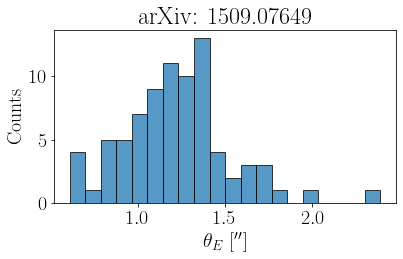

In [4]:
fig, ax = plt.subplots(figsize = (6,4))
plt.hist(data['\theta_E'], bins=20, ec='k', alpha=0.75)
ax.set_xlabel(r"$\theta_E$ [$''$]")
ax.set_ylabel(r"Counts")
ax.set_title(r"arXiv: 1509.07649")
plt.tight_layout()
plt.savefig('theta_E_hist.png', dpi=300)
plt.show()

In [5]:
!convert -trim theta_E_hist.png theta_E_hist.png

# 1: Data from Cao (80 systems)

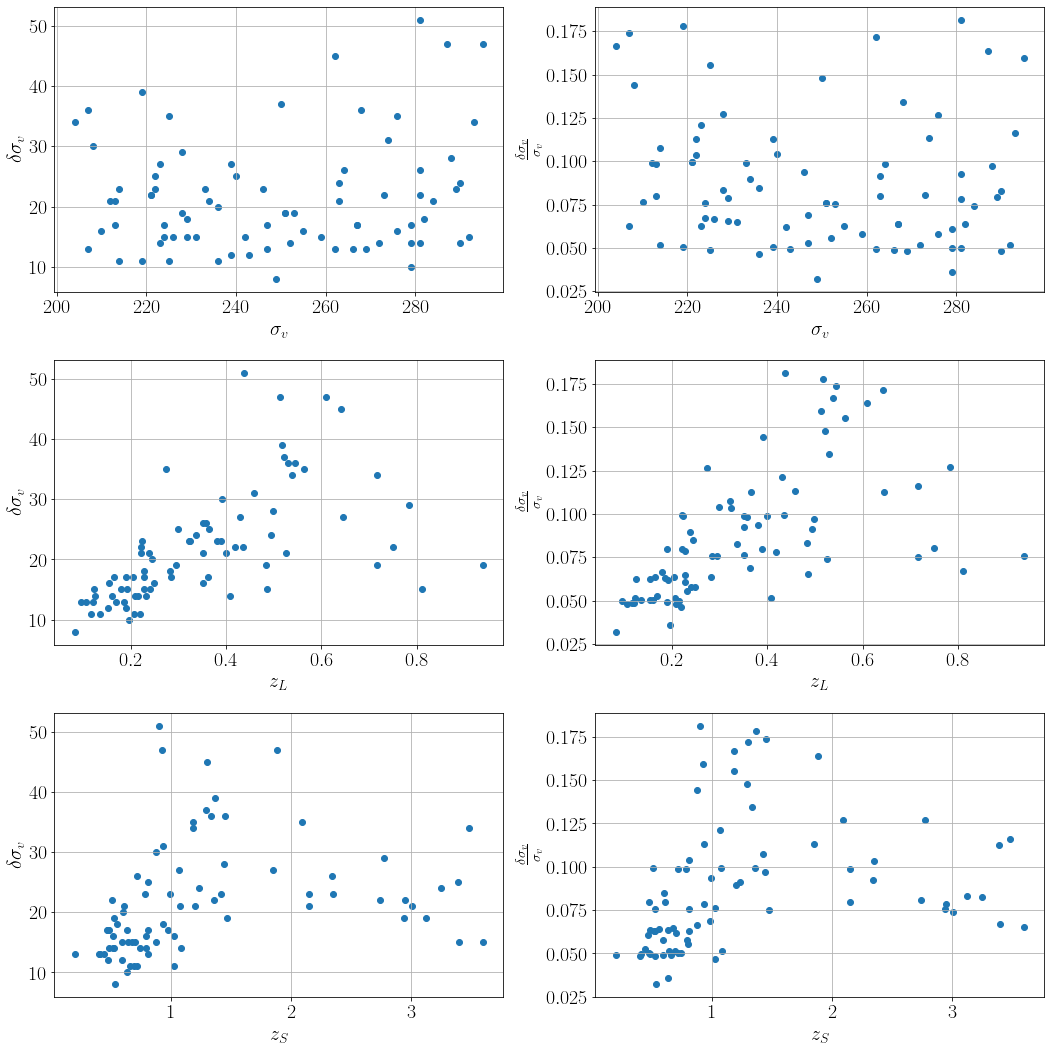

Running burn-in ...


100%|█████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.66it/s]


Sampling ...


100%|█████████████████████████████████████████████████████████| 10000/10000 [03:00<00:00, 55.25it/s]


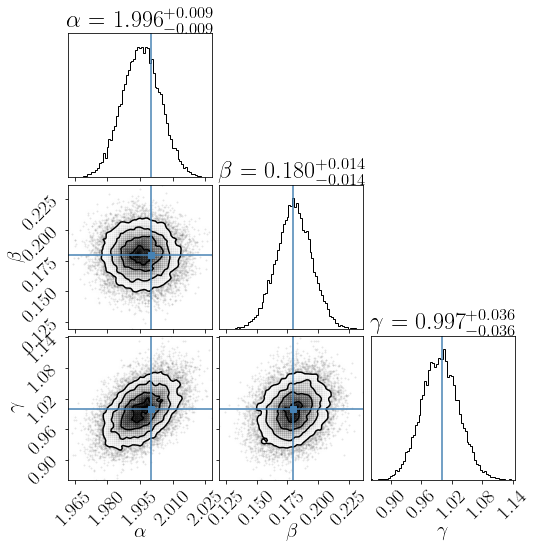

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

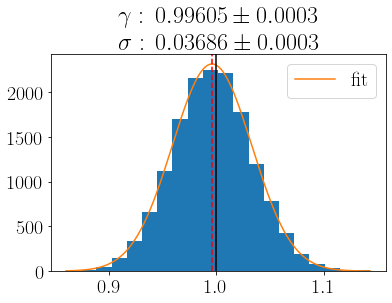

In [6]:
data = data_df
z_L = data['z_L'].values
z_S = data['z_S'].values
theta_E = (data['\theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['\theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['seeing'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['\sigma_ap'].values
velDispErr = data['\sigma_apErr'].values

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(velDisp, velDispErr)
axs[0, 0].set_xlabel('$\sigma_v$')
axs[0, 0].set_ylabel(r'$\delta\sigma_v$')
axs[0, 0].grid()

axs[0, 1].scatter(velDisp, velDispErr/velDisp)
axs[0, 1].set_xlabel('$\sigma_v$')
axs[0, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[0, 1].grid()

axs[1, 0].scatter(z_L, velDispErr)
axs[1, 0].set_xlabel('$z_L$')
axs[1, 0].set_ylabel(r'$\delta\sigma_v$')
axs[1, 0].grid()

axs[1, 1].scatter(z_L, velDispErr/velDisp)
axs[1, 1].set_xlabel('$z_L$')
axs[1, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[1, 1].grid()

axs[2, 0].scatter(z_S, velDispErr)
axs[2, 0].set_xlabel('$z_S$')
axs[2, 0].set_ylabel(r'$\delta\sigma_v$')
axs[2, 0].grid()

axs[2, 1].scatter(z_S, velDispErr/velDisp)
axs[2, 1].set_xlabel('$z_S$')
axs[2, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[2, 1].grid()

plt.tight_layout()
plt.show()

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = alpha_true, beta_ini = beta_true, gamma_ini = gamma_true, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 25)

flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

fig = corner.corner(
    flat_samples, bins=75, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

plt.show()

labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))
    
g = flat_samples[:, 2]

bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title(f"$\gamma:\,{np.round(popt[0], 5)}\pm{np.round(perr[0], 5)}$\n$\sigma:\,{np.round(popt[2], 5)}\pm{np.round(perr[2], 5)}$")
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.axvline(1, color='k')
plt.axvline(popt[0], color='r', linestyle='--')
plt.legend()
plt.show()

# +5:

In this case, we will make both scatter plots and MCMC plots assuming the following conditions:

1. Incertezas por 10% em relação aos valores de $\sigma_v$.
2. Metade das incertezas de $\sigma_v$ ($\delta\sigma_v/2$).
3. Sistemas com o error fracionário > 10%, ou seja $\delta\sigma_v$ > 10% $\sigma_v$: assumir 10% de erro nas incertezas.
4. Sistemas com o error fracionário > 10%, ou seja $\delta\sigma_v$ > 10% $\sigma_v$: assumir 5% de erro nas incertezas.
5. Sistemas com o error fracionário > 5%, ou seja $\delta\sigma_v$ > 5% $\sigma_v$: assumir 5% de erro nas incertezas.

### 1. Incertezas por 10% em relação aos valores de $\sigma_v$.

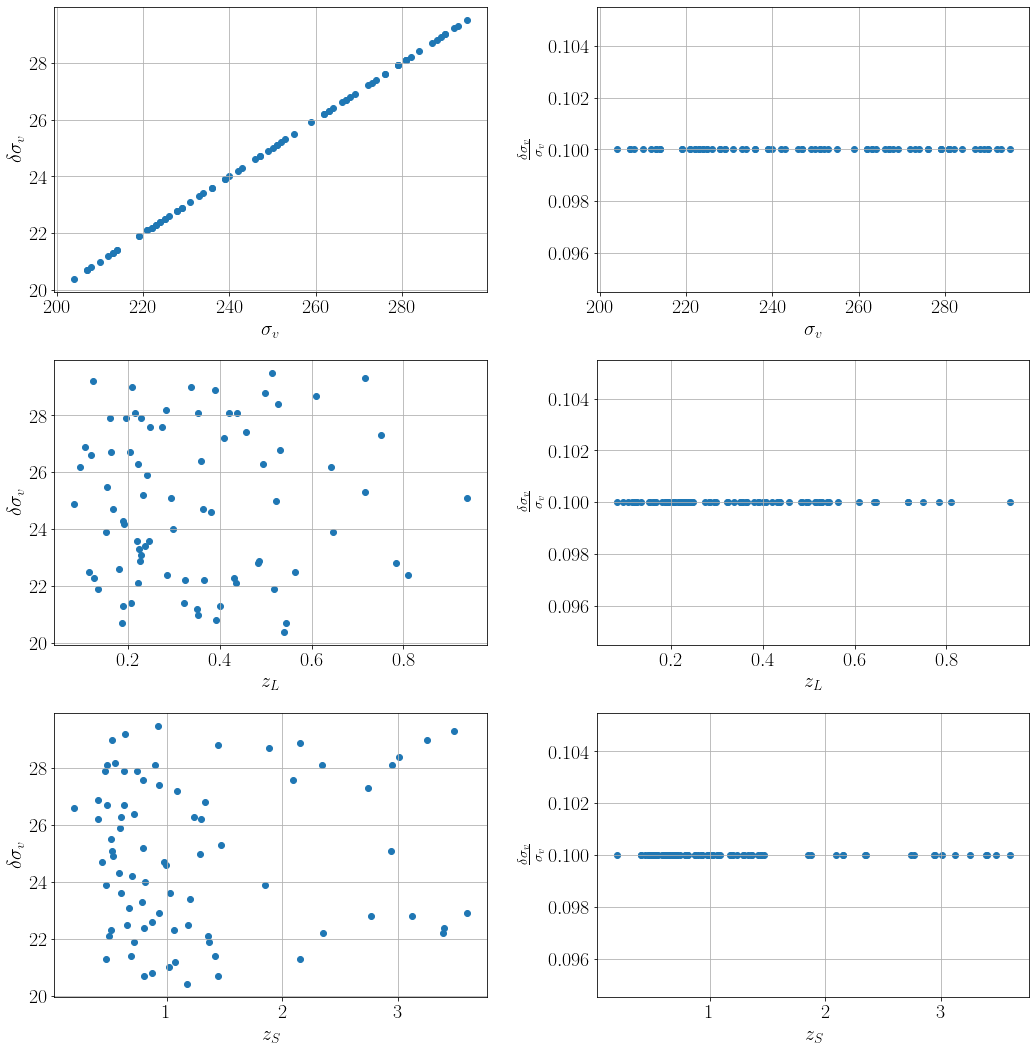

Running burn-in ...


100%|█████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 58.65it/s]


Sampling ...


100%|█████████████████████████████████████████████████████████| 10000/10000 [03:00<00:00, 55.29it/s]


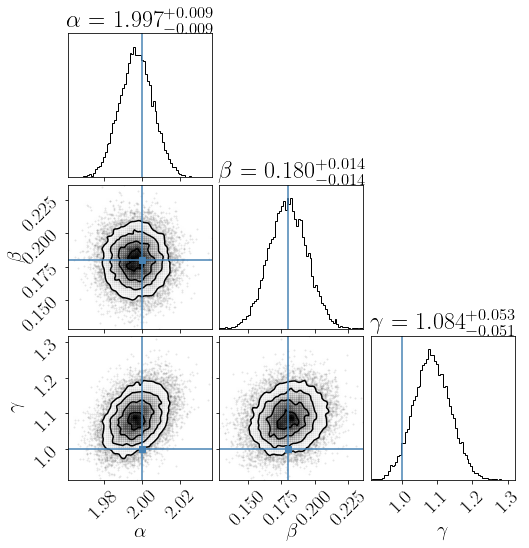

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

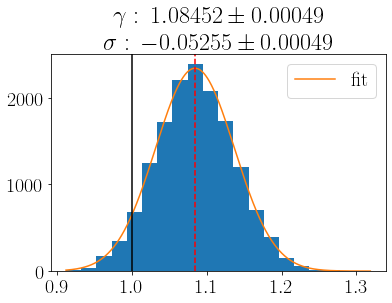

In [7]:
data = data_df
z_L = data['z_L'].values
z_S = data['z_S'].values
theta_E = (data['\theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['\theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['seeing'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['\sigma_ap'].values
velDispErr = velDisp * 0.10

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(velDisp, velDispErr)
axs[0, 0].set_xlabel('$\sigma_v$')
axs[0, 0].set_ylabel(r'$\delta\sigma_v$')
axs[0, 0].grid()

axs[0, 1].scatter(velDisp, velDispErr/velDisp)
axs[0, 1].set_xlabel('$\sigma_v$')
axs[0, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[0, 1].grid()

axs[1, 0].scatter(z_L, velDispErr)
axs[1, 0].set_xlabel('$z_L$')
axs[1, 0].set_ylabel(r'$\delta\sigma_v$')
axs[1, 0].grid()

axs[1, 1].scatter(z_L, velDispErr/velDisp)
axs[1, 1].set_xlabel('$z_L$')
axs[1, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[1, 1].grid()

axs[2, 0].scatter(z_S, velDispErr)
axs[2, 0].set_xlabel('$z_S$')
axs[2, 0].set_ylabel(r'$\delta\sigma_v$')
axs[2, 0].grid()

axs[2, 1].scatter(z_S, velDispErr/velDisp)
axs[2, 1].set_xlabel('$z_S$')
axs[2, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[2, 1].grid()

plt.tight_layout()
plt.show()

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = alpha_true, beta_ini = beta_true, gamma_ini = gamma_true, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 25)

flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

fig = corner.corner(
    flat_samples, bins=75, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

plt.show()

labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))
    
g = flat_samples[:, 2]

bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title(f"$\gamma:\,{np.round(popt[0], 5)}\pm{np.round(perr[0], 5)}$\n$\sigma:\,{np.round(popt[2], 5)}\pm{np.round(perr[2], 5)}$")
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.axvline(1, color='k')
plt.axvline(popt[0], color='r', linestyle='--')
plt.legend()
plt.show()

### 2. Metade das incertezas de $\sigma_v$ ($\delta\sigma_v/2$).

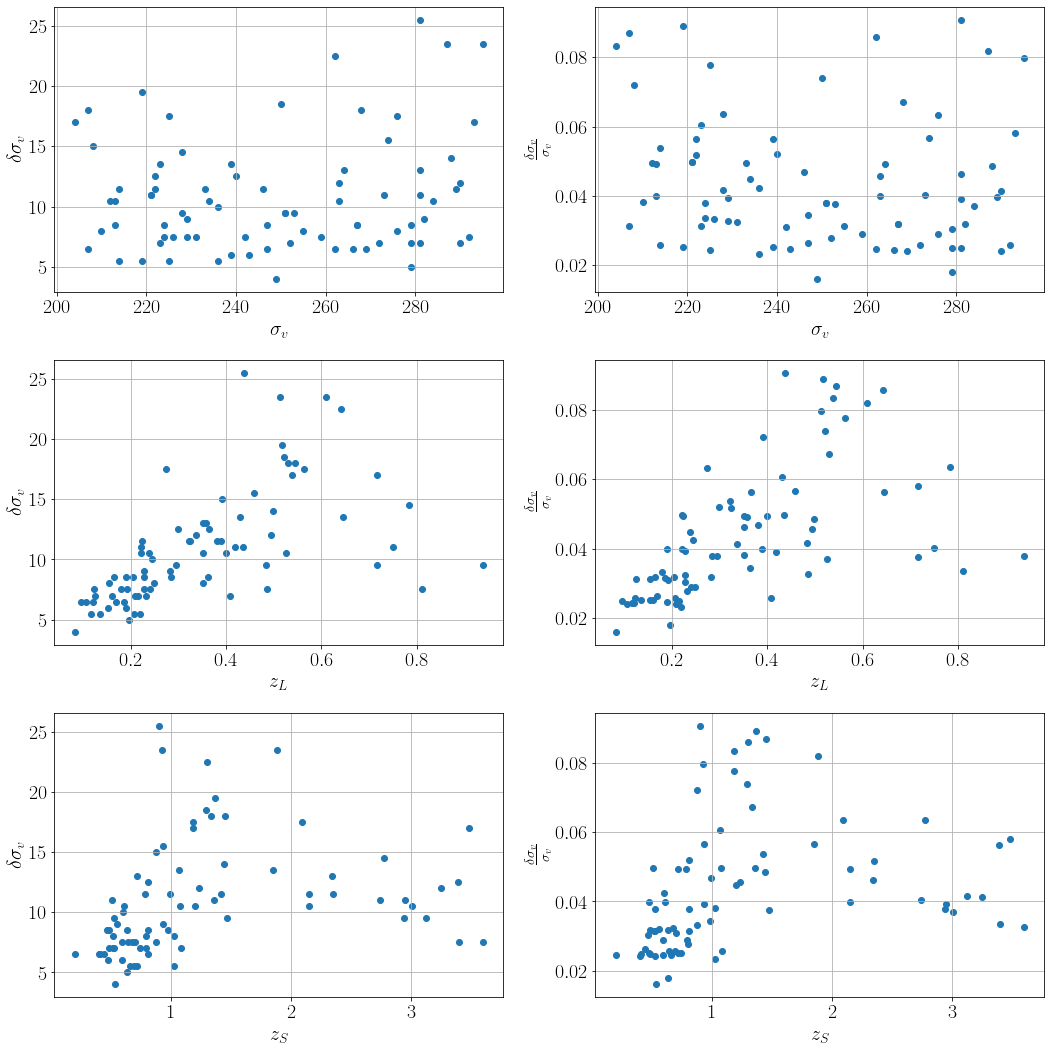

Running burn-in ...


100%|█████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.22it/s]


Sampling ...


100%|█████████████████████████████████████████████████████████| 10000/10000 [03:04<00:00, 54.31it/s]


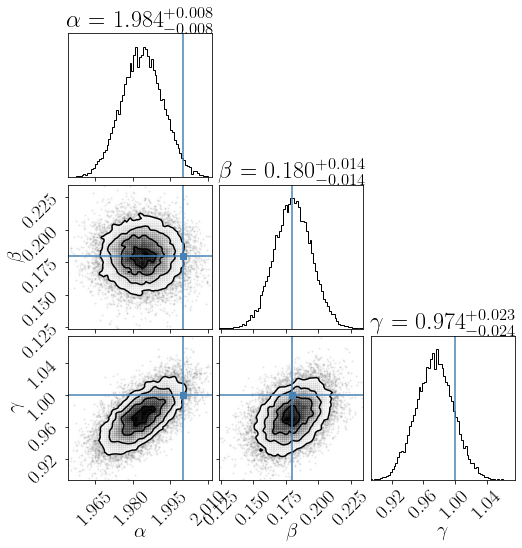

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

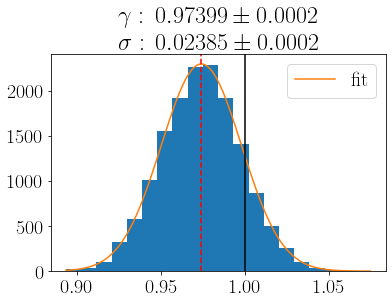

In [8]:
data = data_df
z_L = data['z_L'].values
z_S = data['z_S'].values
theta_E = (data['\theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['\theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['seeing'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['\sigma_ap'].values
velDispErr = data['\sigma_apErr'].values / 2

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(velDisp, velDispErr)
axs[0, 0].set_xlabel('$\sigma_v$')
axs[0, 0].set_ylabel(r'$\delta\sigma_v$')
axs[0, 0].grid()

axs[0, 1].scatter(velDisp, velDispErr/velDisp)
axs[0, 1].set_xlabel('$\sigma_v$')
axs[0, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[0, 1].grid()

axs[1, 0].scatter(z_L, velDispErr)
axs[1, 0].set_xlabel('$z_L$')
axs[1, 0].set_ylabel(r'$\delta\sigma_v$')
axs[1, 0].grid()

axs[1, 1].scatter(z_L, velDispErr/velDisp)
axs[1, 1].set_xlabel('$z_L$')
axs[1, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[1, 1].grid()

axs[2, 0].scatter(z_S, velDispErr)
axs[2, 0].set_xlabel('$z_S$')
axs[2, 0].set_ylabel(r'$\delta\sigma_v$')
axs[2, 0].grid()

axs[2, 1].scatter(z_S, velDispErr/velDisp)
axs[2, 1].set_xlabel('$z_S$')
axs[2, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[2, 1].grid()

plt.tight_layout()
plt.show()

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = alpha_true, beta_ini = beta_true, gamma_ini = gamma_true, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 25)

flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

fig = corner.corner(
    flat_samples, bins=75, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

plt.show()

labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))
    
g = flat_samples[:, 2]

bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title(f"$\gamma:\,{np.round(popt[0], 5)}\pm{np.round(perr[0], 5)}$\n$\sigma:\,{np.round(popt[2], 5)}\pm{np.round(perr[2], 5)}$")
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.axvline(1, color='k')
plt.axvline(popt[0], color='r', linestyle='--')
plt.legend()
plt.show()

### 3. Sistemas com o error fracionário > 10%, ou seja $\delta\sigma_v$ > 10% $\sigma_v$: assumir 10% de erro nas incertezas.

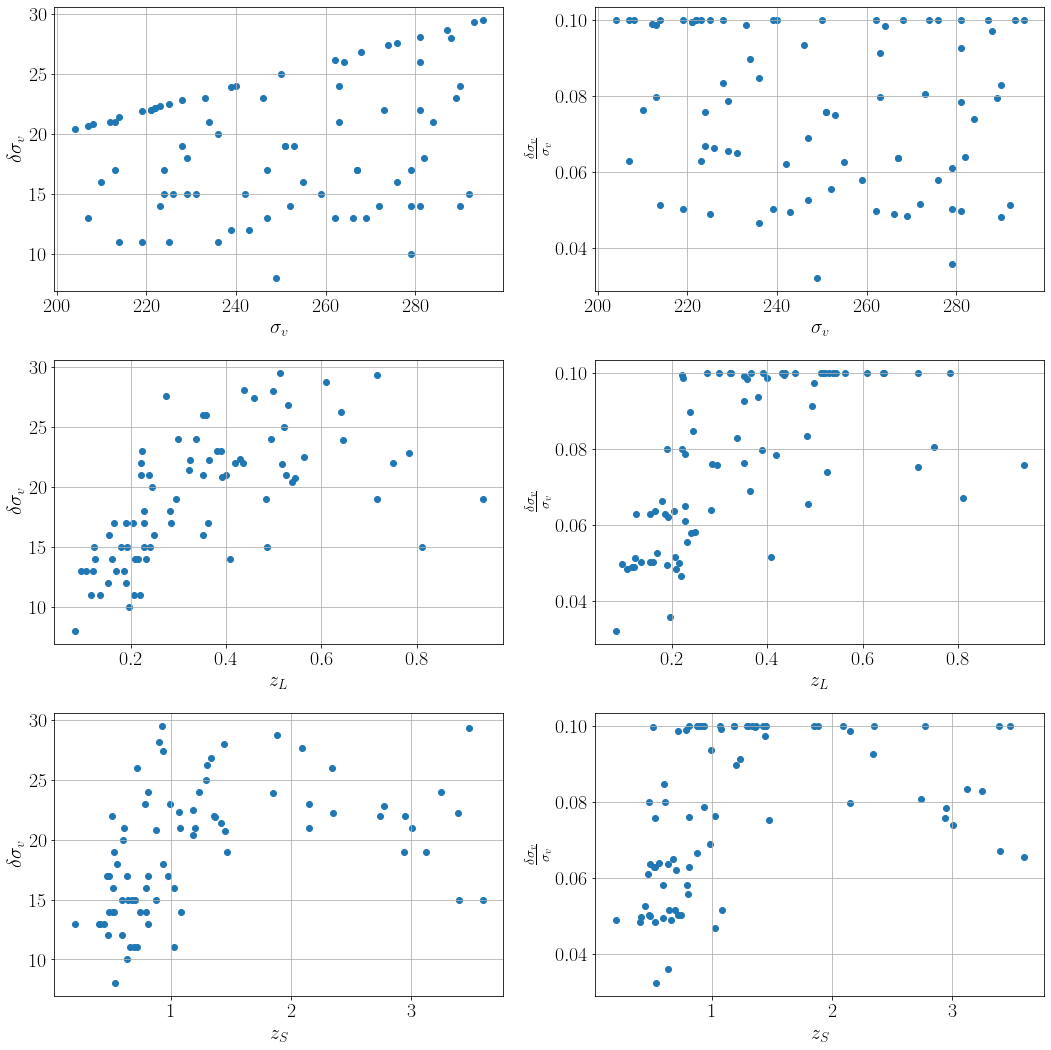

Running burn-in ...


100%|█████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.30it/s]


Sampling ...


100%|█████████████████████████████████████████████████████████| 10000/10000 [03:01<00:00, 55.16it/s]


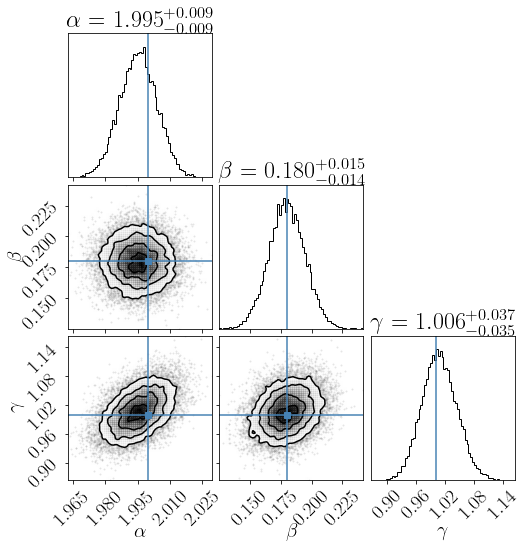

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

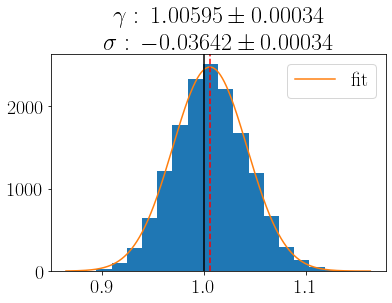

In [9]:
data = data_df
z_L = data['z_L'].values
z_S = data['z_S'].values
theta_E = (data['\theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['\theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['seeing'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['\sigma_ap'].values
velDispErr = data['\sigma_apErr'].values
velDispErr[velDispErr/velDisp > 0.1] = velDisp[velDispErr/velDisp > 0.1] * 0.10

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(velDisp, velDispErr)
axs[0, 0].set_xlabel('$\sigma_v$')
axs[0, 0].set_ylabel(r'$\delta\sigma_v$')
axs[0, 0].grid()

axs[0, 1].scatter(velDisp, velDispErr/velDisp)
axs[0, 1].set_xlabel('$\sigma_v$')
axs[0, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[0, 1].grid()

axs[1, 0].scatter(z_L, velDispErr)
axs[1, 0].set_xlabel('$z_L$')
axs[1, 0].set_ylabel(r'$\delta\sigma_v$')
axs[1, 0].grid()

axs[1, 1].scatter(z_L, velDispErr/velDisp)
axs[1, 1].set_xlabel('$z_L$')
axs[1, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[1, 1].grid()

axs[2, 0].scatter(z_S, velDispErr)
axs[2, 0].set_xlabel('$z_S$')
axs[2, 0].set_ylabel(r'$\delta\sigma_v$')
axs[2, 0].grid()

axs[2, 1].scatter(z_S, velDispErr/velDisp)
axs[2, 1].set_xlabel('$z_S$')
axs[2, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[2, 1].grid()

plt.tight_layout()
plt.show()

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = alpha_true, beta_ini = beta_true, gamma_ini = gamma_true, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 25)

flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

fig = corner.corner(
    flat_samples, bins=75, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

plt.show()

labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))
    
g = flat_samples[:, 2]

bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title(f"$\gamma:\,{np.round(popt[0], 5)}\pm{np.round(perr[0], 5)}$\n$\sigma:\,{np.round(popt[2], 5)}\pm{np.round(perr[2], 5)}$")
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.axvline(1, color='k')
plt.axvline(popt[0], color='r', linestyle='--')
plt.legend()
plt.show()

### 4. Sistemas com o error fracionário > 10%, ou seja $\delta\sigma_v$ > 10% $\sigma_v$: assumir 5% de erro nas incertezas.

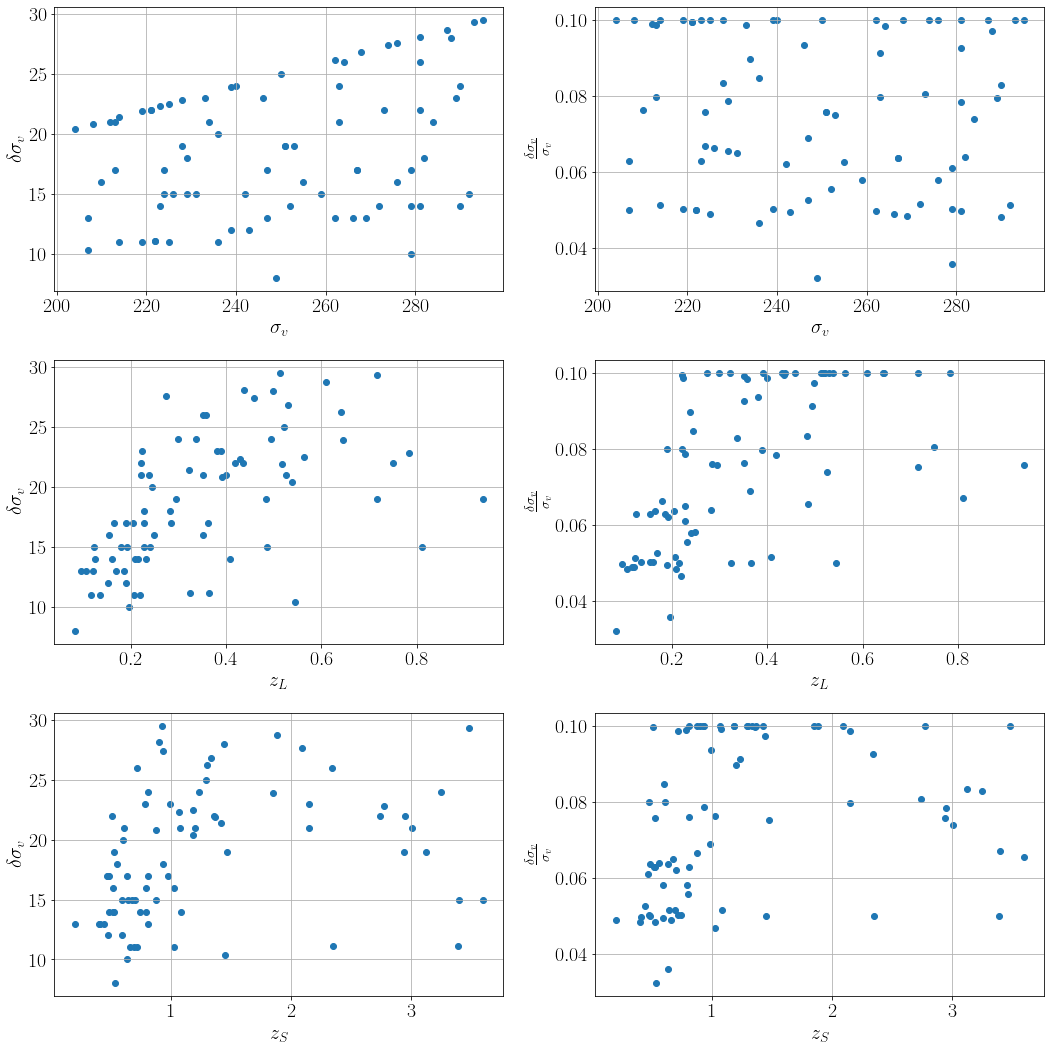

Running burn-in ...


100%|█████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 55.90it/s]


Sampling ...


100%|█████████████████████████████████████████████████████████| 10000/10000 [03:03<00:00, 54.60it/s]


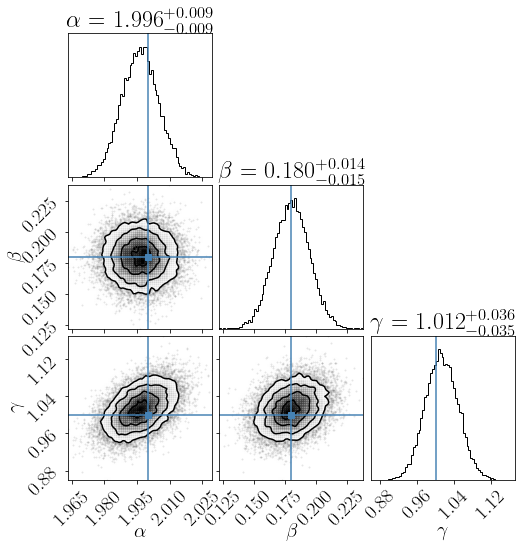

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

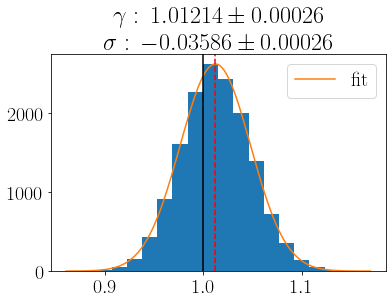

In [10]:
data = data_df
z_L = data['z_L'].values
z_S = data['z_S'].values
theta_E = (data['\theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['\theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['seeing'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['\sigma_ap'].values
velDispErr = data['\sigma_apErr'].values
velDispErr[velDispErr/velDisp > 0.1] = velDisp[velDispErr/velDisp > 0.1] * 0.05

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(velDisp, velDispErr)
axs[0, 0].set_xlabel('$\sigma_v$')
axs[0, 0].set_ylabel(r'$\delta\sigma_v$')
axs[0, 0].grid()

axs[0, 1].scatter(velDisp, velDispErr/velDisp)
axs[0, 1].set_xlabel('$\sigma_v$')
axs[0, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[0, 1].grid()

axs[1, 0].scatter(z_L, velDispErr)
axs[1, 0].set_xlabel('$z_L$')
axs[1, 0].set_ylabel(r'$\delta\sigma_v$')
axs[1, 0].grid()

axs[1, 1].scatter(z_L, velDispErr/velDisp)
axs[1, 1].set_xlabel('$z_L$')
axs[1, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[1, 1].grid()

axs[2, 0].scatter(z_S, velDispErr)
axs[2, 0].set_xlabel('$z_S$')
axs[2, 0].set_ylabel(r'$\delta\sigma_v$')
axs[2, 0].grid()

axs[2, 1].scatter(z_S, velDispErr/velDisp)
axs[2, 1].set_xlabel('$z_S$')
axs[2, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[2, 1].grid()

plt.tight_layout()
plt.show()

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = alpha_true, beta_ini = beta_true, gamma_ini = gamma_true, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 25)

flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

fig = corner.corner(
    flat_samples, bins=75, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

plt.show()

labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))
    
g = flat_samples[:, 2]

bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title(f"$\gamma:\,{np.round(popt[0], 5)}\pm{np.round(perr[0], 5)}$\n$\sigma:\,{np.round(popt[2], 5)}\pm{np.round(perr[2], 5)}$")
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.axvline(1, color='k')
plt.axvline(popt[0], color='r', linestyle='--')
plt.legend()
plt.show()

### 5. Sistemas com o error fracionário > 5%, ou seja $\delta\sigma_v$ > 5% $\sigma_v$: assumir 5% de erro nas incertezas.

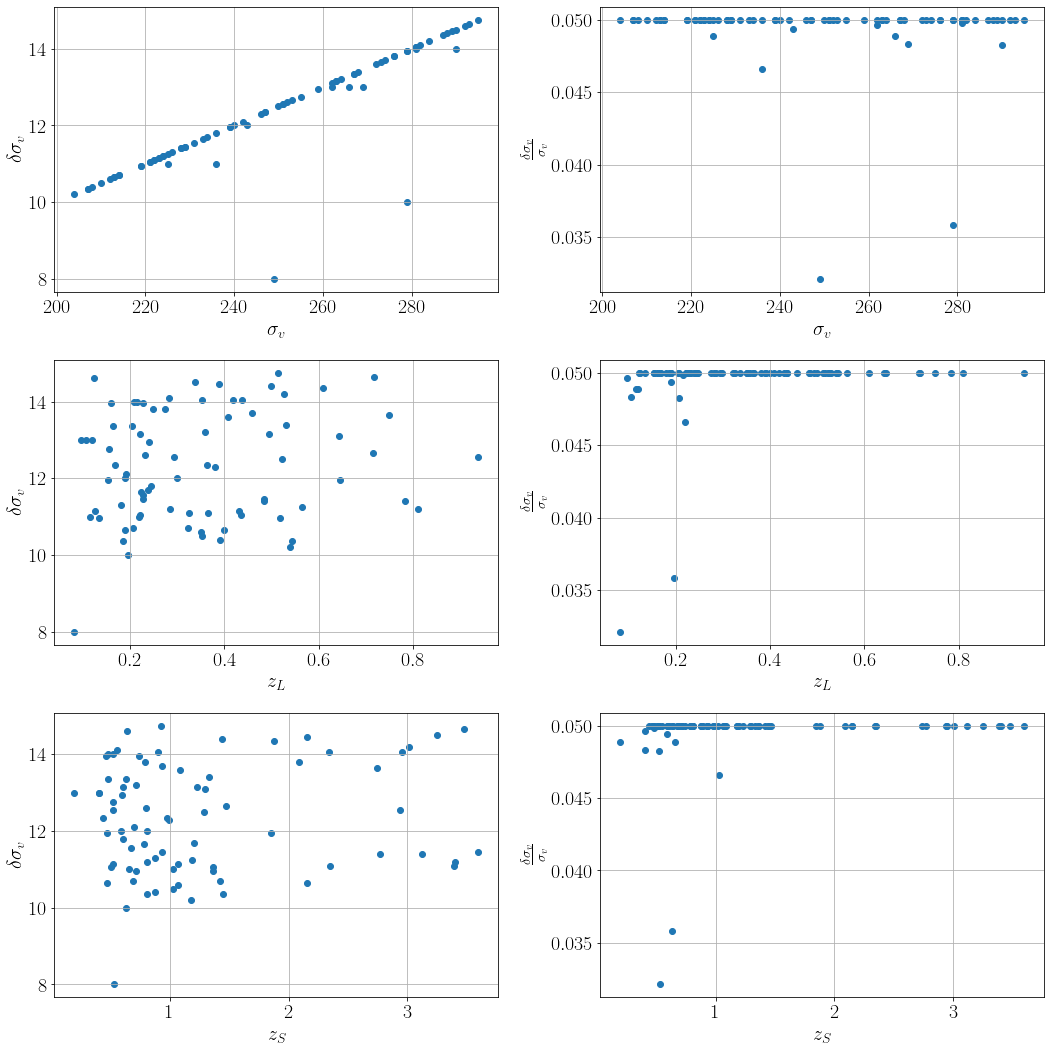

Running burn-in ...


100%|█████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 56.95it/s]


Sampling ...


100%|█████████████████████████████████████████████████████████| 10000/10000 [02:59<00:00, 55.59it/s]


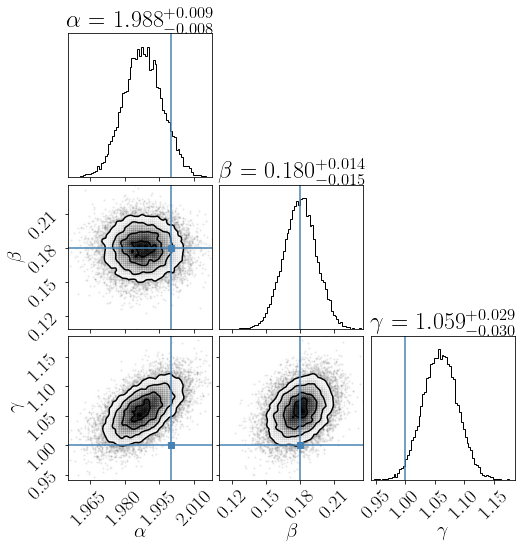

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

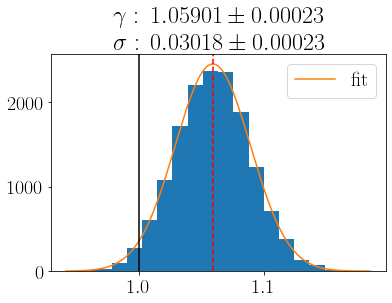

In [11]:
data = data_df
z_L = data['z_L'].values
z_S = data['z_S'].values
theta_E = (data['\theta_E'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
theta_ap = (data['\theta_ap'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
seeing_atm = (data['seeing'].values * rings2cosmo.u.arcsec).to(rings2cosmo.u.rad).value
velDisp = data['\sigma_ap'].values
velDispErr = data['\sigma_apErr'].values
velDispErr[velDispErr/velDisp > 0.05] = velDisp[velDispErr/velDisp > 0.05] * 0.05

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(velDisp, velDispErr)
axs[0, 0].set_xlabel('$\sigma_v$')
axs[0, 0].set_ylabel(r'$\delta\sigma_v$')
axs[0, 0].grid()

axs[0, 1].scatter(velDisp, velDispErr/velDisp)
axs[0, 1].set_xlabel('$\sigma_v$')
axs[0, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[0, 1].grid()

axs[1, 0].scatter(z_L, velDispErr)
axs[1, 0].set_xlabel('$z_L$')
axs[1, 0].set_ylabel(r'$\delta\sigma_v$')
axs[1, 0].grid()

axs[1, 1].scatter(z_L, velDispErr/velDisp)
axs[1, 1].set_xlabel('$z_L$')
axs[1, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[1, 1].grid()

axs[2, 0].scatter(z_S, velDispErr)
axs[2, 0].set_xlabel('$z_S$')
axs[2, 0].set_ylabel(r'$\delta\sigma_v$')
axs[2, 0].grid()

axs[2, 1].scatter(z_S, velDispErr/velDisp)
axs[2, 1].set_xlabel('$z_S$')
axs[2, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[2, 1].grid()

plt.tight_layout()
plt.show()

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

sampler = rings2cosmo.logprobability_sampling(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, 
                            seed = 11, alpha_ini = alpha_true, beta_ini = beta_true, gamma_ini = gamma_true, delta = 2.4, 
                            alpha_0_value = 2.0, eps_alpha_0_value = 0.08, beta_0_value = 0.18, eps_beta_0_value = 0.13, 
                            n_dim = 3, n_walkers = 64, n_burn = 500, n_steps = 10000, progress = True, processes = 25)

flat_samples = sampler.get_chain(discard=500, thin=40, flat=True)
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

fig = corner.corner(
    flat_samples, bins=75, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

plt.show()

labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))
    
g = flat_samples[:, 2]

bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.title(f"$\gamma:\,{np.round(popt[0], 5)}\pm{np.round(perr[0], 5)}$\n$\sigma:\,{np.round(popt[2], 5)}\pm{np.round(perr[2], 5)}$")
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.axvline(1, color='k')
plt.axvline(popt[0], color='r', linestyle='--')
plt.legend()
plt.show()

# Database

Here, we get all data from our database with $\sigma_v$ and $\delta\sigma_v$ and make the same scatter plots (for different colors in SILO, Cao et. al and the rest of the database):

In [2]:
Database = pd.read_csv('../../../../data-mining/Database/Files/Database.csv', low_memory = False)
Database.head()

,JNAME,ID,RA,DEC,Coordinates,Alternate_Name,z_L,z_LErr,z_LQuality,Photo-z_L,...,Emission_Line_Scan_Type,Number_Emission_Lines_SN_>4,Region,Other_Matches,Discovery_Date,Discovery_Acronym,Kind_Acronym,Reference_Identifier,Number_Images,Reference
0,J001615.8+032435.0,HeLMS J001615.8+032435,4.06583,3.40972,00:16:15.80+03:24:35.00,HeLMS13,0.6630,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amvrosiadis et al. (2018) - arXiv:1801.07282
1,J001626.2+042612.0,HeLMS J001626.2+042612,4.10917,4.43667,00:16:26.20+04:26:12.00,HeLMS22,0.2154,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amvrosiadis et al. (2018) - arXiv:1801.07282
2,J004714.2+032453.0,HeLMS J004714.2+032453,11.80917,3.41472,00:47:14.20+03:24:53.00,HeLMS8,0.4780,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amvrosiadis et al. (2018) - arXiv:1801.07282
3,J004723.5+015750.0,HeLMS J004723.5+015750,11.84792,1.96389,00:47:23.50+01:57:50.00,HeLMS9,0.3650,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amvrosiadis et al. (2018) - arXiv:1801.07282
4,J005159.4+062240.0,HeLMS J005159.4+062240,12.99750,6.37778,00:51:59.40+06:22:40.00,HeLMS18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amvrosiadis et al. (2018) - arXiv:1801.07282


In [6]:
Data_Cao = Database[Database['Reference'] == 'Cao et al. (2015) - arXiv:1509.07649'].reset_index(drop=True)
Data_Cao = Data_Cao[['JNAME', 'z_L', 'z_S', 'velDisp', 'velDispErr']].dropna().reset_index(drop=True)

In [7]:
Data_SILO = Database[Database['Reference'] == 'Talbot et al. (2020) - arXiv:2007.09006'].reset_index(drop=True)
Data_SILO = Data_SILO[['JNAME', 'z_L', 'z_S', 'velDisp','velDispErr']].dropna().reset_index(drop=True)

In [8]:
Data_Cut = Database[(Database['Reference'] != 'Talbot et al. (2020) - arXiv:2007.09006') & \
                    (Database['Reference'] != 'Cao et al. (2015) - arXiv:1509.07649')].reset_index(drop=True)
Data_Cut = Data_Cut[['JNAME', 'z_L', 'z_S', 'velDisp','velDispErr']].dropna().reset_index(drop=True)

In [27]:
Data_SOAR_Sample = pd.read_csv('SOAR_Sample.csv')
Data_SOAR_Sample.head()

,z_L,z_S,sigma_v,sigma_vErr
0,0.28000,0.610,NaN,NaN
1,0.67000,0.980,NaN,NaN
2,0.24145,1.405,242.58,21.736
3,0.57350,0.880,235.30,21.442
4,0.28000,0.610,NaN,NaN


In [38]:
Data_SOAR_Sample = Data_SOAR_Sample.rename(columns={'sigma_v': 'velDisp', 'sigma_vErr': 'velDispErr'})

In [9]:
len(Data_Cao), len(Data_SILO), len(Data_Cut)

(118, 1402, 711)

In [10]:
Data_Cao['JNAME'].unique().shape, Data_SILO['JNAME'].unique().shape, Data_Cut['JNAME'].unique().shape

((118,), (1397,), (409,))

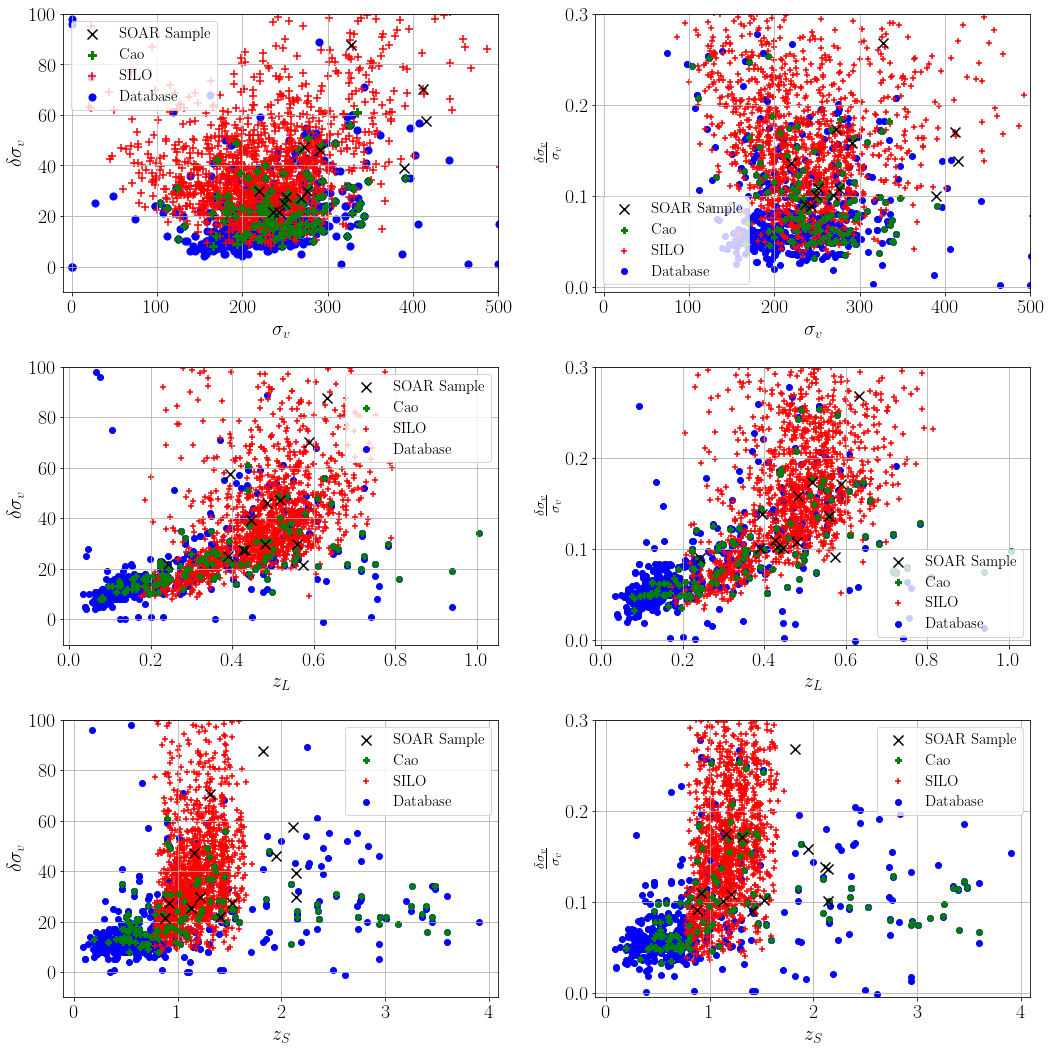

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].scatter(Data_SOAR_Sample['velDisp'], Data_SOAR_Sample['velDispErr'], \
                  marker = 'x', color = 'k', label = 'SOAR Sample', zorder = 3, s = 100)
axs[0, 0].scatter(Data_Cao['velDisp'], Data_Cao['velDispErr'], marker = 'P', color = 'g', label = 'Cao', zorder = 2, s = 50)
axs[0, 0].scatter(Data_SILO['velDisp'], Data_SILO['velDispErr'], marker = '+', color = 'r', label = 'SILO', zorder = 1, s = 50)
axs[0, 0].scatter(Data_Cut['velDisp'], Data_Cut['velDispErr'], marker = 'o', color = 'b', label = 'Database', zorder = 0, s = 50)
axs[0, 0].legend(fontsize=15)
axs[0, 0].set_ylim(-10, 100)
axs[0, 0].set_xlim(-10, 500)
axs[0, 0].set_xlabel('$\sigma_v$')
axs[0, 0].set_ylabel(r'$\delta\sigma_v$')
axs[0, 0].grid()

axs[0, 1].scatter(Data_SOAR_Sample['velDisp'], Data_SOAR_Sample['velDispErr']/Data_SOAR_Sample['velDisp'], \
                  marker = 'x', color = 'k', label = 'SOAR Sample', zorder = 3, s = 100)
axs[0, 1].scatter(Data_Cao['velDisp'], Data_Cao['velDispErr']/Data_Cao['velDisp'], marker = 'P', color = 'g', label = 'Cao', zorder = 2)
axs[0, 1].scatter(Data_SILO['velDisp'], Data_SILO['velDispErr']/Data_SILO['velDisp'], marker = '+', color = 'r', label = 'SILO', zorder = 1)
axs[0, 1].scatter(Data_Cut['velDisp'], Data_Cut['velDispErr']/Data_Cut['velDisp'], marker = 'o', color = 'b', label = 'Database', zorder = 0)
axs[0, 1].legend(fontsize=15)
axs[0, 1].set_ylim(-0.005, 0.3)
axs[0, 1].set_xlim(-10, 500)
axs[0, 1].set_xlabel('$\sigma_v$')
axs[0, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[0, 1].grid()

axs[1, 0].scatter(Data_SOAR_Sample['z_L'], Data_SOAR_Sample['velDispErr'], \
                  marker = 'x', color = 'k', label = 'SOAR Sample', zorder = 3, s = 100)
axs[1, 0].scatter(Data_Cao['z_L'], Data_Cao['velDispErr'], marker = 'P', color = 'g', label = 'Cao', zorder = 2)
axs[1, 0].scatter(Data_SILO['z_L'], Data_SILO['velDispErr'], marker = '+', color = 'r', label = 'SILO', zorder = 1)
axs[1, 0].scatter(Data_Cut['z_L'], Data_Cut['velDispErr'], marker = 'o', color = 'b', label = 'Database', zorder = 0)
axs[1, 0].legend(fontsize=15)
axs[1, 0].set_ylim(-10, 100)
axs[1, 0].set_xlabel('$z_L$')
axs[1, 0].set_ylabel(r'$\delta\sigma_v$')
axs[1, 0].grid()

axs[1, 1].scatter(Data_SOAR_Sample['z_L'], Data_SOAR_Sample['velDispErr']/Data_SOAR_Sample['velDisp'], \
                  marker = 'x', color = 'k', label = 'SOAR Sample', zorder = 3, s = 100)
axs[1, 1].scatter(Data_Cao['z_L'], Data_Cao['velDispErr']/Data_Cao['velDisp'], marker = 'P', color = 'g', label = 'Cao', zorder = 2)
axs[1, 1].scatter(Data_SILO['z_L'], Data_SILO['velDispErr']/Data_SILO['velDisp'], marker = '+', color = 'r', label = 'SILO', zorder = 1)
axs[1, 1].scatter(Data_Cut['z_L'], Data_Cut['velDispErr']/Data_Cut['velDisp'], marker = 'o', color = 'b', label = 'Database', zorder = 0)
axs[1, 1].legend(fontsize=15)
axs[1, 1].set_ylim(-0.005, 0.3)
axs[1, 1].set_xlabel('$z_L$')
axs[1, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[1, 1].grid()

axs[2, 0].scatter(Data_SOAR_Sample['z_S'], Data_SOAR_Sample['velDispErr'], \
                  marker = 'x', color = 'k', label = 'SOAR Sample', zorder = 3, s = 100)
axs[2, 0].scatter(Data_Cao['z_S'], Data_Cao['velDispErr'], marker = 'P', color = 'g', label = 'Cao', zorder = 2)
axs[2, 0].scatter(Data_SILO['z_S'], Data_SILO['velDispErr'], marker = '+', color = 'r', label = 'SILO', zorder = 1)
axs[2, 0].scatter(Data_Cut['z_S'], Data_Cut['velDispErr'], marker = 'o', color = 'b', label = 'Database', zorder = 0)
axs[2, 0].legend(fontsize=15)
axs[2, 0].set_ylim(-10, 100)
axs[2, 0].set_xlabel('$z_S$')
axs[2, 0].set_ylabel(r'$\delta\sigma_v$')
axs[2, 0].grid()

axs[2, 1].scatter(Data_SOAR_Sample['z_S'], Data_SOAR_Sample['velDispErr']/Data_SOAR_Sample['velDisp'], \
                  marker = 'x', color = 'k', label = 'SOAR Sample', zorder = 3, s = 100)
axs[2, 1].scatter(Data_Cao['z_S'], Data_Cao['velDispErr']/Data_Cao['velDisp'], marker = 'P', color = 'g', label = 'Cao', zorder = 2)
axs[2, 1].scatter(Data_SILO['z_S'], Data_SILO['velDispErr']/Data_SILO['velDisp'], marker = '+', color = 'r', label = 'SILO', zorder = 1)
axs[2, 1].scatter(Data_Cut['z_S'], Data_Cut['velDispErr']/Data_Cut['velDisp'], marker = 'o', color = 'b', label = 'Database', zorder = 0)
axs[2, 1].legend(fontsize=15)
axs[2, 1].set_ylim(-0.005, 0.3)
axs[2, 1].set_xlabel('$z_S$')
axs[2, 1].set_ylabel(r'$\frac{\delta\sigma_v}{\sigma_v}$')
axs[2, 1].grid()

plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300)
plt.show()

In [54]:
!convert -trim scatter_plot.png scatter_plot.png

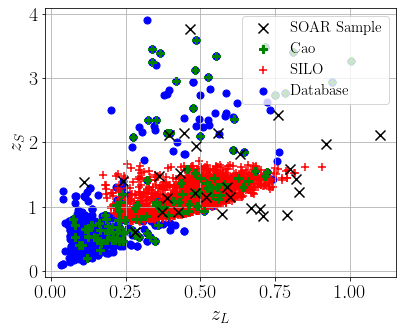

In [62]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))

axs.scatter(Data_SOAR_Sample['z_L'], Data_SOAR_Sample['z_S'], \
                  marker = 'x', color = 'k', label = 'SOAR Sample', zorder = 3, s = 100)
axs.scatter(Data_Cao['z_L'], Data_Cao['z_S'], marker = 'P', color = 'g', label = 'Cao', zorder = 2, s = 50)
axs.scatter(Data_SILO['z_L'], Data_SILO['z_S'], marker = '+', color = 'r', label = 'SILO', zorder = 1, s = 50)
axs.scatter(Data_Cut['z_L'], Data_Cut['z_S'], marker = 'o', color = 'b', label = 'Database', zorder = 0, s = 50)
axs.legend(fontsize=15)
axs.set_xlabel('$z_L$')
axs.set_ylabel('$z_S$')
axs.grid()

plt.tight_layout()
plt.savefig('z_L_vs_z_S.png', dpi=300)
plt.show()

In [63]:
!convert -trim z_L_vs_z_S.png z_L_vs_z_S.png